In [60]:
from scripts.estimate_roa import load_ground_truth
import os
from os import path
import mg_diffuse
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/common/home/st1122/Projects/mg_diffuse/")

In [61]:
dataset = "pendulum_lqr_50k"
path_prefix = "diffusion"

In [62]:
gt_data = load_ground_truth(dataset)
start_points = gt_data[:, :2]
expected_labels = gt_data[:, 2]

[ scripts/estimate_roa ] Loading ground truth


In [63]:
from scripts.estimate_roa import load_dataset_params

params = load_dataset_params(dataset)
attractors = params["attractors"]
attractor_threshold = params["attractor_threshold"]
invalid_label = params["invalid_label"]
attractor_probability_upper_threshold = params["attractor_probability_upper_threshold"]

In [64]:
from scripts.estimate_roa import get_labels_array


start_points = gt_data[:, :2]
expected_labels = gt_data[:, 2]

labels_set, labels_array = get_labels_array(expected_labels, invalid_label)

In [158]:
exp_name = "25_02_16-18_03_43_H32_T20_PADT_EPSF_ATNF_LD1_data_lim_100"
timestamp = '2025-02-20_16-43-44'
n_runs = 20
model_state_name = "best.pt"


exp_path = path.join("experiments", dataset, path_prefix, exp_name, "generated_trajectories", timestamp)

In [159]:
from scripts.estimate_roa import load_final_states_data

final_states_path = path.join("experiments", dataset, path_prefix, exp_name, "generated_trajectories", timestamp, "final_states")

all_predicted_labels, all_final_states = load_final_states_data(final_states_path, n_runs, invalid_label)
all_final_states = all_final_states.transpose(1, 0, 2)
all_predicted_labels = all_predicted_labels.transpose(1, 0)

[ scripts/estimate_roa ] Loading attractor labels


100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


Invalid labels count: 14909


In [160]:
attractor_labels = [
    "Fail - Left",
    "Fail - Right",
    "Success",
]

attractor_coordinates = [
    np.array([-2.1, 0]),
    np.array([2.1, 0]),
    np.array([0, 0]),
]

In [161]:
attractor_threshold = 0.05

In [162]:
closest_attractor_indices = []
closest_attractor_distances = []

for i, start_point in tqdm(enumerate(start_points)):
    final_states_across_runs = all_final_states[i]

    # Calculate distances to all attractors for each final state
    attractor_distances = np.array([
        np.linalg.norm(final_states_across_runs - attractor_coord, axis=1) 
        for attractor_coord in attractor_coordinates
    ])
    
    # Get index of closest attractor and corresponding distance for each final state
    closest_attractor_idx = np.argmin(attractor_distances, axis=0)
    min_distances = np.min(attractor_distances, axis=0)

    # If the minimum distance is greater than the attractor threshold, set the label to invalid
    closest_attractor_idx[min_distances > attractor_threshold] = invalid_label

    closest_attractor_indices.append(closest_attractor_idx)
    closest_attractor_distances.append(min_distances)
    
closest_attractor_distances = np.array(closest_attractor_distances, dtype=np.float32)
closest_attractor_indices = np.array(closest_attractor_indices, dtype=np.int32)

2545it [00:00, 25444.38it/s]

790653it [00:31, 25032.76it/s]


In [163]:
# Calculate probabilities for each attractor efficiently using numpy operations
n_points = len(start_points)
n_attractors = len(attractor_labels) + 1  # Add 1 for invalid label

# Use numpy's bincount to count occurrences for each point and attractor
# Reshape to handle all points at once
flattened_indices = closest_attractor_indices.reshape(-1)
point_indices = np.repeat(np.arange(n_points), closest_attractor_indices.shape[1])

# Create a 2D array of counts using advanced indexing
counts = np.zeros((n_points, n_attractors))
np.add.at(counts, (point_indices, flattened_indices), 1)

# Convert counts to probabilities by dividing by number of runs
probabilities = counts / closest_attractor_indices.shape[1]

print("Probabilities shape:", probabilities.shape)
print("\nSample probabilities for first 5 points:")
for i in range(min(5, n_points)):
    probs_dict = {label: f"{prob:.3f}" for label, prob in zip(attractor_labels, probabilities[i, :-1])}
    print(f"Point {i}:", f"Start point: {start_points[i]}", 
          probs_dict,
          f"Invalid: {probabilities[i, -1]:.3f}")


Probabilities shape: (790653, 4)

Sample probabilities for first 5 points:
Point 0: Start point: [-3.14 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 1: Start point: [-3.13 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 2: Start point: [-3.12 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 3: Start point: [-3.11 -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000
Point 4: Start point: [-3.1  -6.28] {'Fail - Left': '0.000', 'Fail - Right': '0.000', 'Success': '1.000'} Invalid: 0.000


In [164]:
# Get the attractor probability upper threshold from config
attractor_probability_upper_threshold = params["attractor_probability_upper_threshold"]

# Find points where any attractor (including invalid) has probability above threshold
certain_mask = np.any(probabilities >= attractor_probability_upper_threshold, axis=1)

# Get indices of certain and uncertain points
certain_indices = np.where(certain_mask)[0]
uncertain_indices = np.where(~certain_mask)[0]

# For certain points, get the label with highest probability (including invalid label)
all_probs = np.column_stack([probabilities, 
                            counts[:,-1]/closest_attractor_indices.shape[1]])
certain_labels = np.argmax(all_probs[certain_mask], axis=1)

# Store the results
certain_points = start_points[certain_indices]
certain_point_labels = certain_labels
uncertain_points = start_points[uncertain_indices]

print(f"\nNumber of certain points: {len(certain_points)}")
print(f"Number of uncertain points: {len(uncertain_points)}")
print("\nLabel distribution for certain points:")
unique_labels, label_counts = np.unique(certain_point_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    if label < len(attractor_labels):
        print(f"Attractor {attractor_labels[label]}: {count}")
    else:
        print(f"Invalid: {count}")



Number of certain points: 776533
Number of uncertain points: 14120

Label distribution for certain points:
Attractor Fail - Left: 246870
Attractor Fail - Right: 231880
Attractor Success: 297782
Invalid: 1


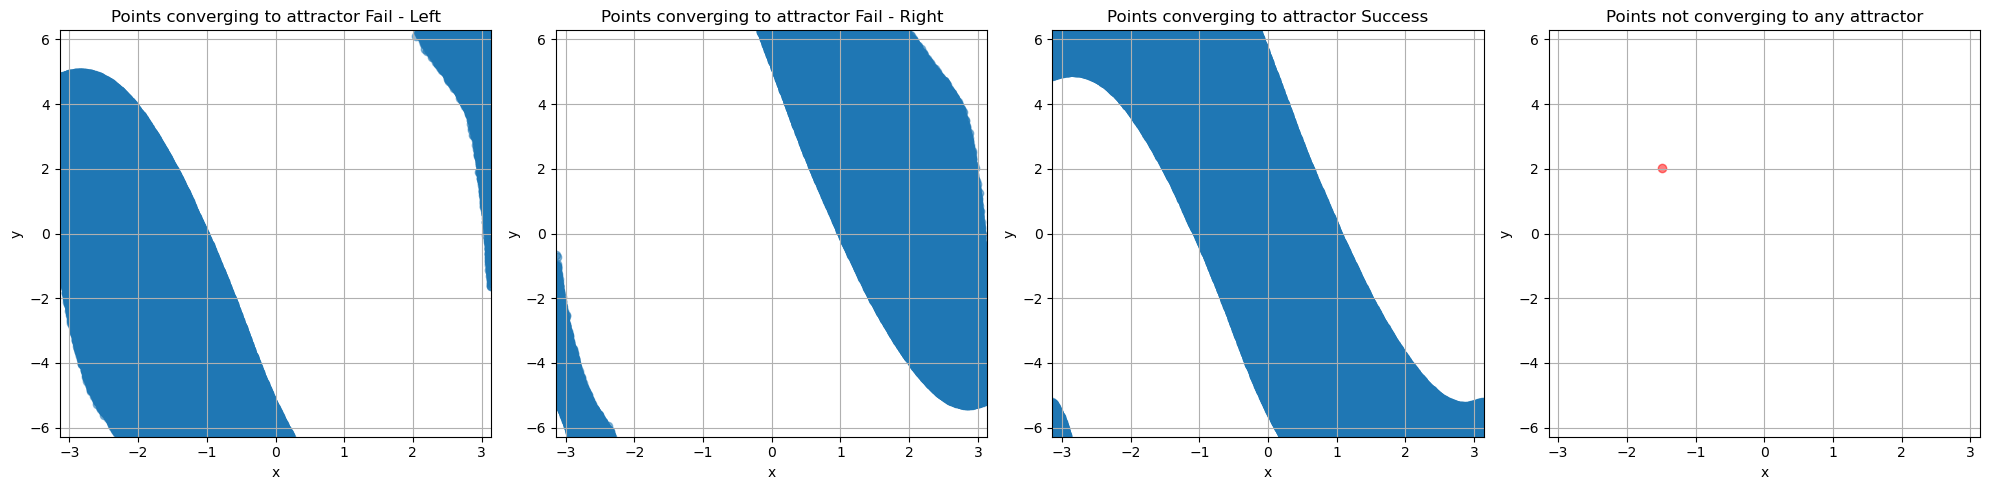

In [165]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each attractor and invalid points
n_plots = len(attractor_labels) + 1  # +1 for invalid points
fig, axes = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))

# Get overall min and max for x and y coordinates
x_min = certain_points[:, 0].min()
x_max = certain_points[:, 0].max()
y_min = certain_points[:, 1].min()
y_max = certain_points[:, 1].max()

# Plot points for each attractor
for i, label in enumerate(attractor_labels):
    mask = certain_point_labels == i
    axes[i].scatter(certain_points[mask, 0], certain_points[mask, 1], alpha=0.5)
    axes[i].set_title(f'Points converging to attractor {label}')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    axes[i].grid(True)
    axes[i].set_xlim(x_min, x_max)
    axes[i].set_ylim(y_min, y_max)

# Plot invalid points
mask = certain_point_labels == len(attractor_labels)
axes[-1].scatter(certain_points[mask, 0], certain_points[mask, 1], alpha=0.5, color='red')
axes[-1].set_title('Points not converging to any attractor')
axes[-1].set_xlabel('x')
axes[-1].set_ylabel('y')
axes[-1].grid(True)
axes[-1].set_xlim(x_min, x_max)
axes[-1].set_ylim(y_min, y_max)

plt.tight_layout()

plt.savefig(path.join(exp_path, "certain_points.png"), dpi=300, bbox_inches='tight')

In [166]:
# Get final states for points labeled as invalid
invalid_mask = certain_point_labels == len(attractor_labels)
invalid_final_states = all_final_states[certain_indices[invalid_mask]]
print("Final states shape for invalid points:", invalid_final_states.shape)
print("\nSample of final states for invalid points:")
print(invalid_final_states[:])

Final states shape for invalid points: (1, 20, 2)

Sample of final states for invalid points:
[[[-2.1515753e+00  1.6960934e-01]
  [-2.1052930e+00  1.0300256e-01]
  [-2.1277981e+00  1.5395069e-01]
  [-2.6352664e-03 -2.0610881e-03]
  [-2.1474788e+00  1.7890526e-01]
  [-3.7134688e-03  3.5667117e-03]
  [-2.0910058e+00  1.6814163e-02]
  [-2.1101420e+00  1.2156368e-01]
  [-2.1695468e+00  1.7004633e-01]
  [-2.1349382e+00  1.6659068e-01]
  [-2.1080251e+00  1.1926780e-01]
  [-2.1181691e+00  1.3157707e-01]
  [-1.9243660e+00 -8.2694781e-01]
  [-1.4551546e-01  3.5852218e-01]
  [-2.0955992e+00  7.3491678e-02]
  [-2.0957382e+00  6.3388571e-02]
  [-2.0922096e+00  4.7768943e-02]
  [-2.0952737e+00  6.4448453e-02]
  [-2.1405065e+00  1.7934281e-01]
  [-2.0999939e+00  8.4550709e-02]]]


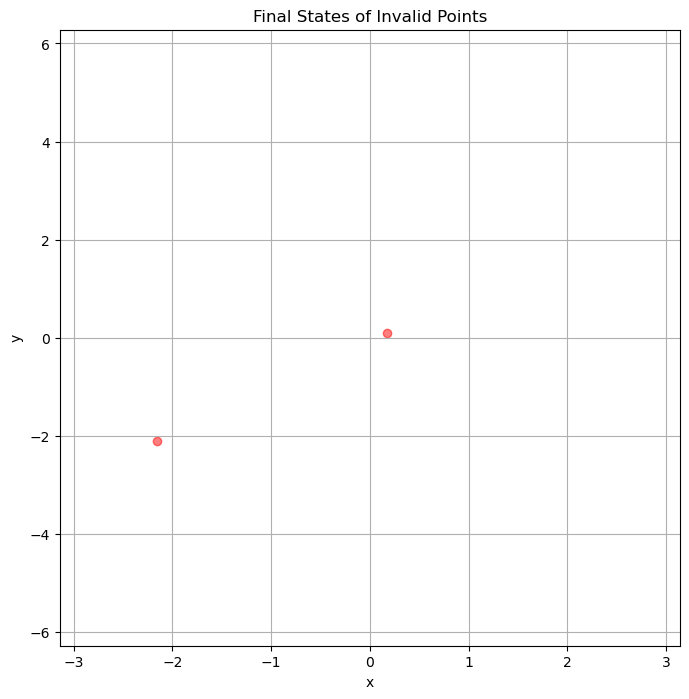

In [167]:
# Create a scatter plot of invalid final states
plt.figure(figsize=(8, 8))
plt.scatter(invalid_final_states[:, 0], invalid_final_states[:, 1], alpha=0.5, color='red')
plt.title('Final States of Invalid Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(axes[0].get_xlim())  # Use same x limits as first attractor plot
plt.ylim(axes[0].get_ylim())  # Use same y limits as first attractor plot

plt.savefig(path.join(exp_path, "invalid_final_states.png"), dpi=300, bbox_inches='tight')


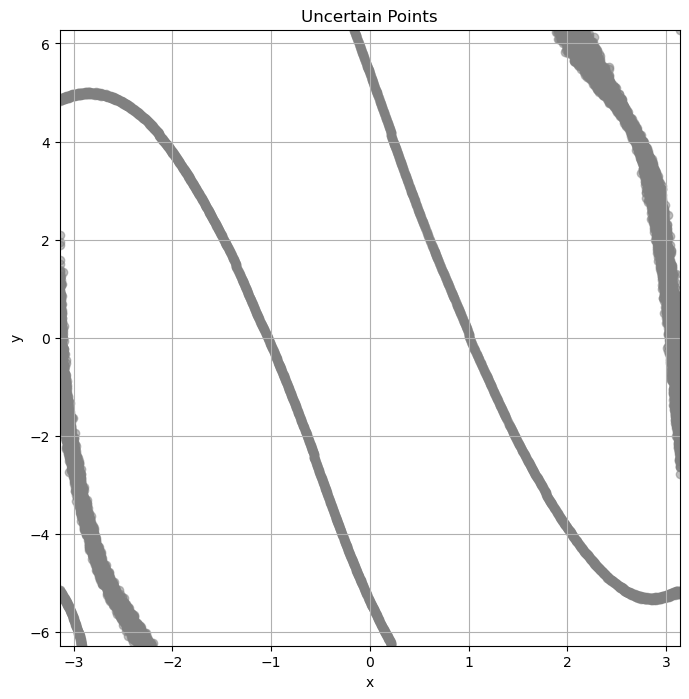

In [168]:
plt.figure(figsize=(8, 8))
plt.scatter(uncertain_points[:, 0], uncertain_points[:, 1], alpha=0.5, color='gray')
plt.title('Uncertain Points')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(x_min, x_max)  # Use same limits as previous plots
plt.ylim(y_min, y_max)

plt.savefig(path.join(exp_path, "uncertain_points.png"), dpi=300, bbox_inches='tight')



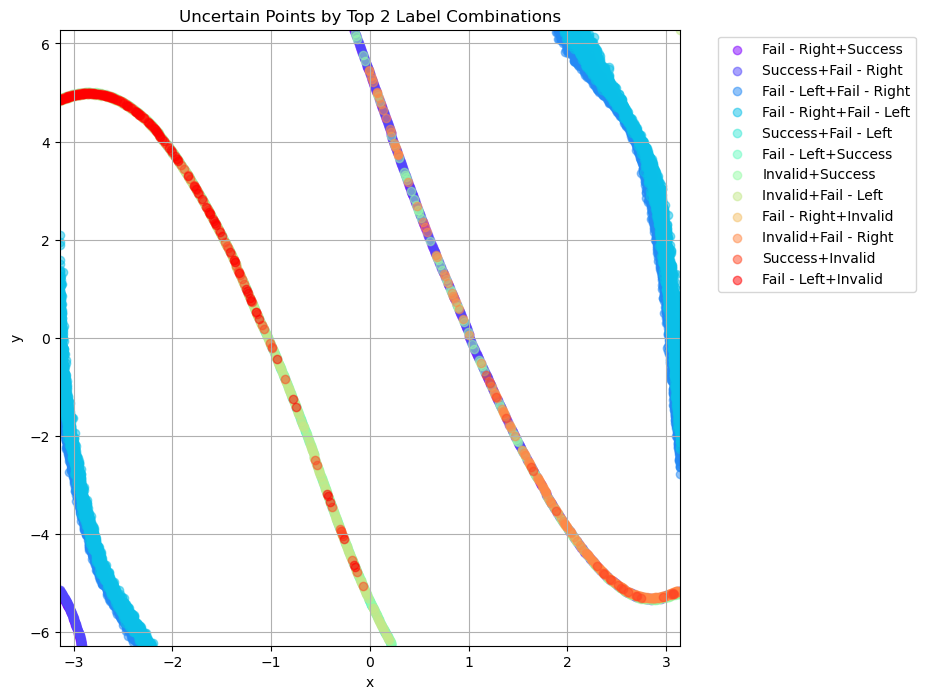

In [169]:
# Get top 2 dominant labels for uncertain points
uncertain_probabilities = probabilities[uncertain_indices]
label_combinations = []
points_by_combination = []

for point_idx, point_probs in enumerate(uncertain_probabilities):
    # Get indices of top 2 highest probabilities
    top_2_indices = np.argsort(point_probs)[-2:]
    # Convert to tuple for hashing
    label_combo = tuple([attractor_labels[label_idx] if label_idx < len(attractor_labels) else "Invalid" for label_idx in top_2_indices])
    
    if label_combo not in label_combinations:
        label_combinations.append(label_combo)
        points_by_combination.append([uncertain_points[point_idx]])
    else:
        combo_idx = label_combinations.index(label_combo)
        points_by_combination[combo_idx].append(uncertain_points[point_idx])

# Convert lists of points to numpy arrays
points_by_combination = [np.array(points) for points in points_by_combination]

# Create plot
plt.figure(figsize=(8, 8))

# Use a different color for each combination
colors = plt.cm.rainbow(np.linspace(0, 1, len(label_combinations)))

for i, (combo, points) in enumerate(zip(label_combinations, points_by_combination)):
    label_str = f"{'+'.join(str(l) for l in combo)}"
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5, color=colors[i], label=label_str)

plt.title('Uncertain Points by Top 2 Label Combinations')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig(path.join(exp_path, "uncertain_points_by_combination.png"), dpi=300, bbox_inches='tight')
